In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [2]:
resolution = 64

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=20,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution]
)

Downloading...
From: https://drive.google.com/uc?id=1hQzdQpudGTBZ7x0nURPzlV5DTcqcb1sm
To: /home/jaeminseo/Documents/neuraloperator-main/projects/data/darcy_ZD_PWC_train_64.pt
100%|██████████| 3.28M/3.28M [00:00<00:00, 5.58MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1qsstWhpdYRkj7dTSeVpfDFWknj0LpCPw
From (redirected): https://drive.google.com/uc?id=1qsstWhpdYRkj7dTSeVpfDFWknj0LpCPw&confirm=t&uuid=d125ee08-30db-46f9-bf09-7fff0b721cef
To: /home/jaeminseo/Documents/neuraloperator-main/projects/data/darcy_ZD_PWC_test_64.pt
100%|██████████| 65.5M/65.5M [00:11<00:00, 5.94MB/s]

Loading test db for resolution 64 with 50 samples 


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FNO(
    n_modes=(16, 16),
    hidden_channels=64,
    in_channels=1,
    out_channels=1
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

/home/jaeminseo/anaconda3/envs/PINN/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Our model has 4769473 parameters.


In [4]:
n_epochs = 100
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [5]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'FNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tjwoals217 (tjwoals217-Chung-Ang University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([20, 1, 64, 64])
[0] time=0.52, avg_loss=1.0167, train_err=16.9450
Eval: 64_h1=0.9987, 64_l2=0.5554
[1] time=0.13, avg_loss=1.0034, train_err=16.7226
Eval: 64_h1=0.9817, 64_l2=0.5656
[2] time=0.17, avg_loss=0.9957, train_err=16.5950
Eval: 64_h1=0.9826, 64_l2=0.5670
[3] time=0.16, avg_loss=0.9927, train_err=16.5444
Eval: 64_h1=0.9754, 64_l2=0.5602
[4] time=0.17, avg_loss=0.9859, train_err=16.4308
Eval: 64_h1=0.9713, 64_l2=0.5536
[5] time=0.17, avg_loss=0.9776, train_err=16.2939
Eval: 64_h1=0.9558, 64_l2=0.5497
[6] time=0.15, avg_loss=0.9552, train_err=15.9207
Eval: 64_h1=0.9280, 64_l2=0.5426
[7] time=0.19, avg_loss=0.9169, train_err=15.2819
Eval: 64_h1=0.9059, 64_l2=0.5399
[8] time=0.14, avg_loss=0.8854, train_err=14.7559
Eval: 64_h1=0.8723, 64_l2=0.5305
[9] time=0.15, avg_loss=0.8412, train_err=14.0194
Eval: 64_h1=0.8329, 64_l2=0.5005
[10] time=0.15, avg_loss=0.7988, train_err=13

{'train_err': 1.4199944658369261,
 'avg_loss': 0.08519966795021557,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.16945692617446184,
 '64_h1': tensor(0.1668, device='cuda:0', dtype=torch.float64),
 '64_l2': tensor(0.0699, device='cuda:0', dtype=torch.float64)}

In [7]:
wandb.finish()

64_h1,███▇▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_l2,█████▇▇▅▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,█▇▇▇▆▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
time,▁▅▆█▃▄█▆▆▇▄▄▄▇▄▅▅▄▄▄▆▅▅▄▅▆▆▆▆▇▆▄▂▃▅▄▄▅▆▅
train_err,█████▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_h1,0.16677
64_l2,0.06986
avg_loss,0.0852
lr,0
time,0.16946


L2 error (0) : 0.10010355464186885
L2 error (1) : 0.055829170395519365
L2 error (2) : 0.07533661402599051


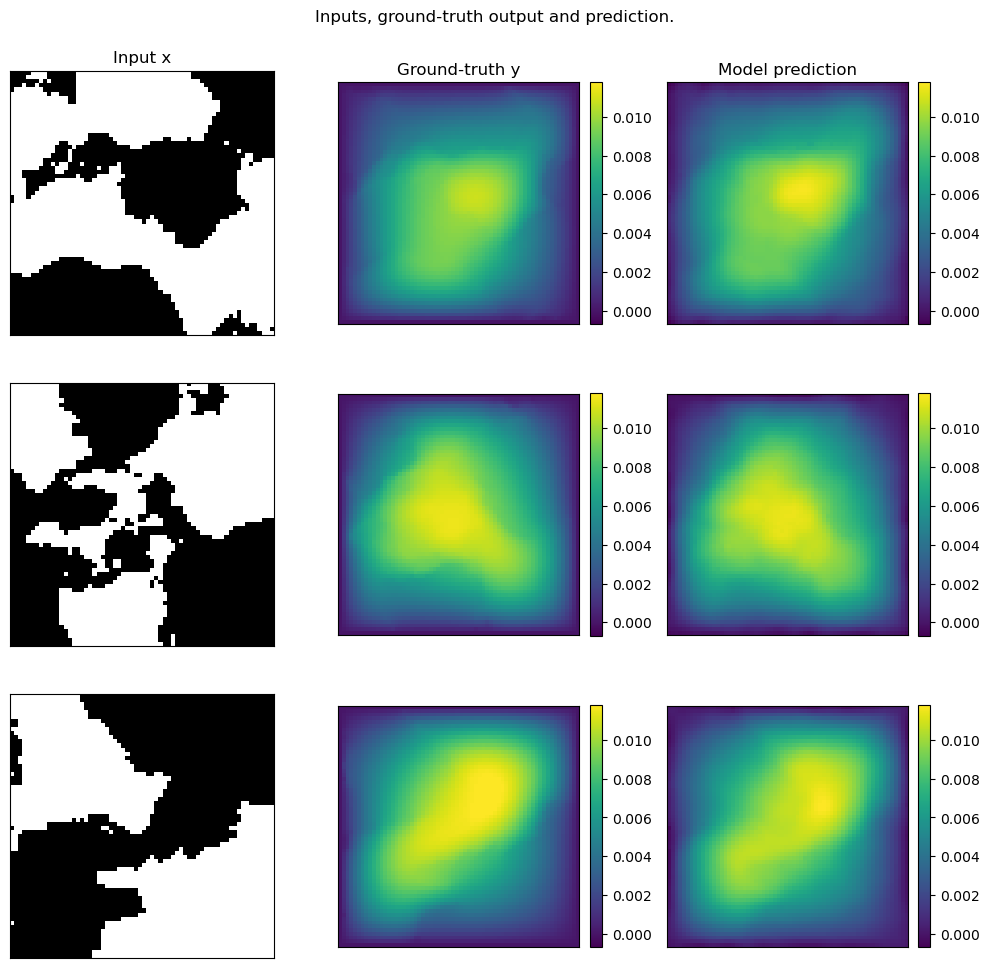

In [8]:
test_samples = test_loaders[64].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0))

    y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x.unsqueeze(0)).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()